In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
from pathlib import Path
import os
from PIL import Image
import torchvision.transforms.functional as TF
from IPython.display import display
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from torch import nn
import torch

In [52]:
dataset_dir = Path('/kaggle/input/gnr638')
train_dir = dataset_dir / "train-kaggle" / "train-kaggle"

(480, 270)


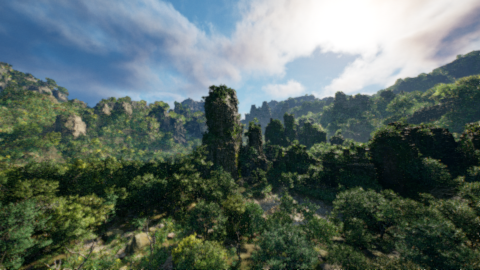

In [53]:
lr_im = Image.open(train_dir / "lr" / "00002.png")
print(lr_im.size)
lr_im

(1920, 1080)


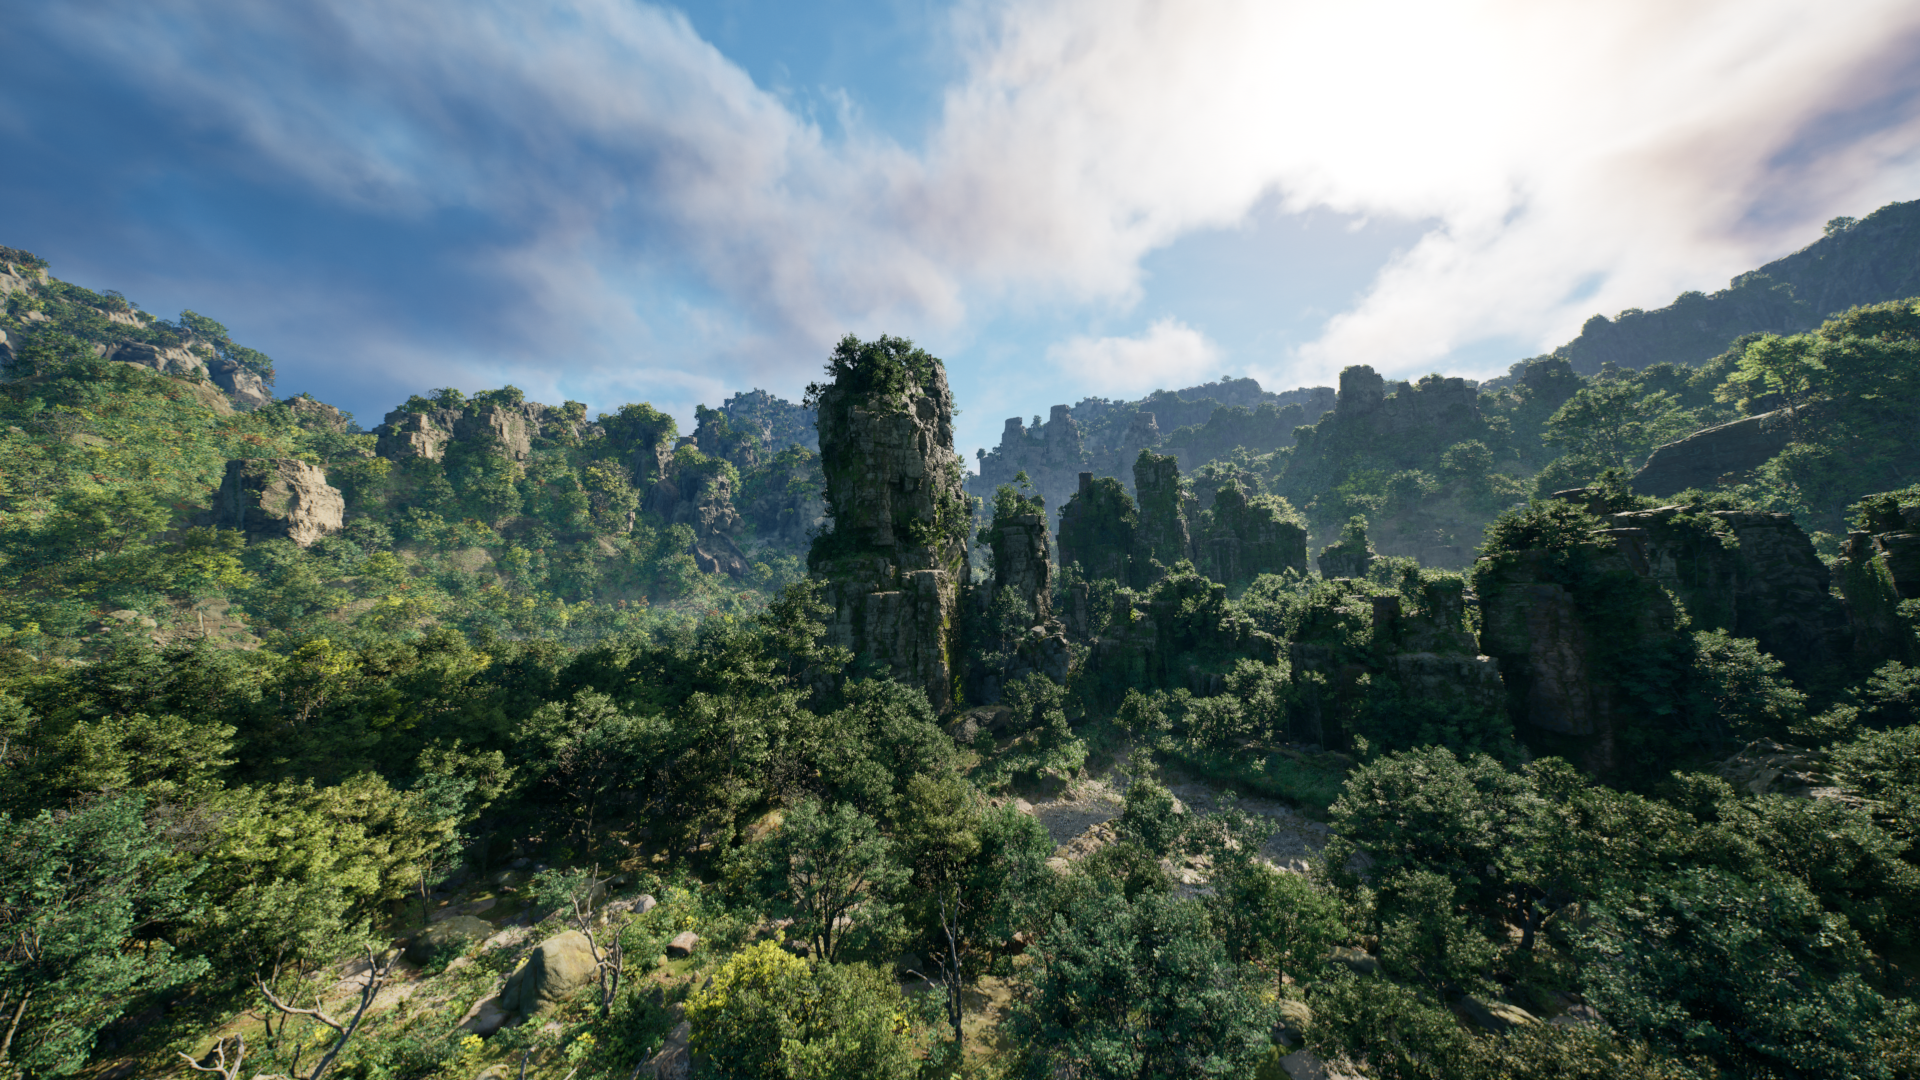

In [54]:
hr_im = Image.open(train_dir / "hr" / "00002.png")
print(hr_im.size)
hr_im

In [55]:
# Creating Custom Dataset
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx])).convert("RGB")
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert("RGB")

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

In [56]:
dataset = SuperResolutionDataset(train_dir / "lr", train_dir / "hr", transform=transform)
len(dataset)

4500

In [57]:
# ViT Model

class PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=768, patch_size=16):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        return self.proj(x)  # [B, embed_dim, H/patch, W/patch]

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class ViTSuperResolution(nn.Module):
    def __init__(self, embed_dim=64, depth=6):
        super().__init__()

        # Shallow feature extraction (no big patching)
        self.initial = nn.Conv2d(3, embed_dim, kernel_size=3, padding=1)

        self.transformer = nn.Sequential(
            *[TransformerBlock(embed_dim) for _ in range(depth)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),  # 64 → 256
            nn.PixelShuffle(2),  # 2x upsample
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),  # 4x total upsample
            nn.Conv2d(64, 3, kernel_size=3, padding=1)  # Final RGB
        )

    def forward(self, x):
        x = self.initial(x)  # [B, embed_dim, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, HW, C]
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.upsample(x)
        return x


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [68]:
num_epochs = 1
model = ViTSuperResolution().to(device)
criterion = nn.L1Loss()  # For image reconstruction tasks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [69]:
import matplotlib.pyplot as plt
from tqdm import tqdm

loss_history = []

model.train()
for epoch in range(num_epochs):
    for i, (lr_img, hr_img) in tqdm(enumerate(dataloader)):
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)

        optimizer.zero_grad()
        sr_img = model(lr_img)

        loss = criterion(sr_img, hr_img)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()

        loss_history.append(batch_loss)
        # print(f"Batch {i+1}: Loss = {batch_loss:.6f}")


4500it [47:30,  1.58it/s]


In [70]:
torch.save(model.state_dict(), "/kaggle/working/model_final.pth")

In [71]:
from torchsummary import summary
import torch

# Set device to CPU
device = torch.device("cpu")

# Initialize model
model = ViTSuperResolution().to(device)

# Load model weights (map to CPU)
model.load_state_dict(torch.load("/kaggle/input/vit3/pytorch/default/1/model_final_vit.pth", map_location=device))

# Use summary with a model on CPU — must force input size to CPU too
summary(model, (3, 480, 270), device="cpu")


/tmp/ipykernel_31/3166410402.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/vit3/pytorch/default/1/model_final_vit.pth"

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 270]           1,792
         LayerNorm-2           [-1, 129600, 64]             128
         LayerNorm-3           [-1, 129600, 64]             128
         LayerNorm-4           [-1, 129600, 64]             128
MultiheadAttention-5  [[-1, 129600, 64], [-1, 2, 2]]               0
         LayerNorm-6           [-1, 129600, 64]             128
            Linear-7          [-1, 129600, 256]          16,640
              GELU-8          [-1, 129600, 256]               0
            Linear-9           [-1, 129600, 64]          16,448
 TransformerBlock-10           [-1, 129600, 64]               0
        LayerNorm-11           [-1, 129600, 64]             128
        LayerNorm-12           [-1, 129600, 64]             128
        LayerNorm-13           [-1, 129600, 64]             128
MultiheadAttention-14  [[-1, 12960

torch.Size([3, 1080, 1920])


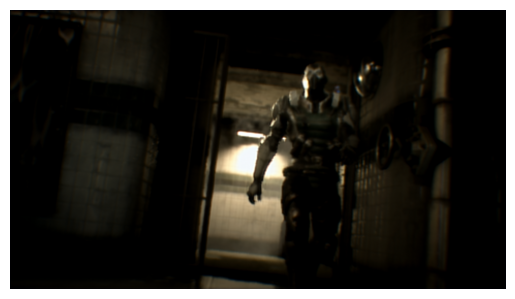

In [72]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model = model.to(device)

input_img = dataset[0][0]  # Tensor image

img = transform(TF.to_pil_image(input_img)).to(device)

with torch.no_grad():
    output = model(img.unsqueeze(0))

output_img = output.squeeze(0).detach().cpu()

output_img = output_img.clamp(0, 1)

print(output_img.shape)
plt.imshow(to_pil_image(output_img))
plt.axis('off')
plt.show()


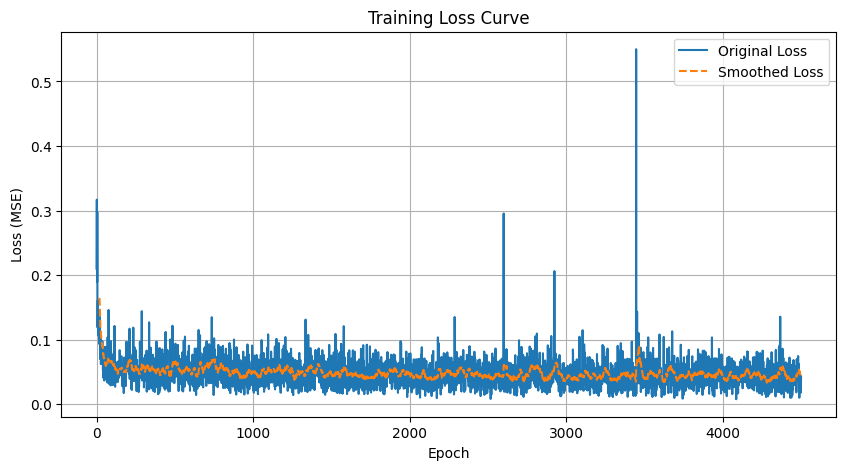

In [84]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 20
smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')

# Plot the original and smoothed loss curve
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(loss_history)), loss_history, label='Original Loss')
plt.plot(np.arange(window_size-1, len(loss_history)), smoothed_loss, label='Smoothed Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [85]:
test_dir = dataset_dir / "lr" / "lr"

In [86]:
im_paths = os.listdir(test_dir)
im_paths.sort()
print(len(im_paths))

500


00176.png


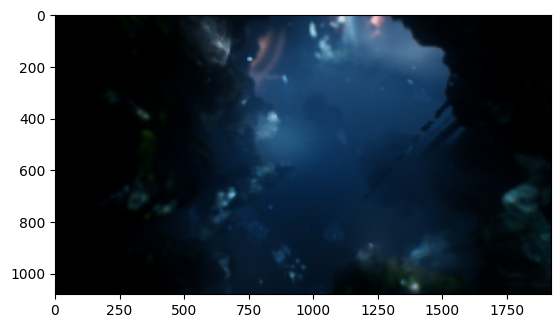

In [87]:
from PIL import Image
import torch

img = Image.open(test_dir / im_paths[0])
print(im_paths[0])

if img.mode == 'RGBA':
    img = img.convert('RGB')

img_tensor = transform(img) 

img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(img_tensor)

output_img = output.squeeze(0).detach().cpu()

output_img = output_img.clamp(0, 1)
plt.imshow(output_img.permute(1, 2, 0))

In [88]:
if not os.path.exists("/kaggle/working/hr/"):
    os.makedirs("/kaggle/working/hr/", exist_ok=True)
else:
    print("Directory already exists")


In [89]:
for im_path in im_paths:
    img = Image.open(test_dir / im_path)
    
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    
    img_tensor = transform(img) 
    
    img_tensor = img_tensor.unsqueeze(0)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    output_img = output.squeeze(0).detach().cpu()
    
    output_img = output_img.clamp(0, 1)
    output_img = output_img.permute(1, 2, 0)

    output_img = output_img.numpy()

    save_path = f"/kaggle/working/hr/{im_path}"
    plt.imsave(save_path, output_img)

    print(f"Saved image: {save_path}")


Saved image: /kaggle/working/hr/00176.png
Saved image: /kaggle/working/hr/00215.png
Saved image: /kaggle/working/hr/00282.png
Saved image: /kaggle/working/hr/00377.png
Saved image: /kaggle/working/hr/00473.png
Saved image: /kaggle/working/hr/00511.png
Saved image: /kaggle/working/hr/00551.png
Saved image: /kaggle/working/hr/00562.png
Saved image: /kaggle/working/hr/00571.png
Saved image: /kaggle/working/hr/00581.png
Saved image: /kaggle/working/hr/00588.png
Saved image: /kaggle/working/hr/00609.png
Saved image: /kaggle/working/hr/00621.png
Saved image: /kaggle/working/hr/00660.png
Saved image: /kaggle/working/hr/00728.png
Saved image: /kaggle/working/hr/00747.png
Saved image: /kaggle/working/hr/00755.png
Saved image: /kaggle/working/hr/00775.png
Saved image: /kaggle/working/hr/00782.png
Saved image: /kaggle/working/hr/00787.png
Saved image: /kaggle/working/hr/00819.png
Saved image: /kaggle/working/hr/00843.png
Saved image: /kaggle/working/hr/00854.png
Saved image: /kaggle/working/hr/00

In [90]:
!zip -r /kaggle/working/hr.zip /kaggle/working/hr

  adding: kaggle/working/hr/ (stored 0%)
  adding: kaggle/working/hr/08198.png (deflated 0%)
  adding: kaggle/working/hr/02803.png (deflated 0%)
  adding: kaggle/working/hr/05802.png (deflated 0%)
  adding: kaggle/working/hr/04911.png (deflated 0%)
  adding: kaggle/working/hr/07328.png (deflated 0%)
  adding: kaggle/working/hr/12149.png (deflated 0%)
  adding: kaggle/working/hr/03181.png (deflated 0%)
  adding: kaggle/working/hr/10651.png (deflated 0%)
  adding: kaggle/working/hr/06565.png (deflated 0%)
  adding: kaggle/working/hr/01127.png (deflated 0%)
  adding: kaggle/working/hr/10877.png (deflated 1%)
  adding: kaggle/working/hr/11006.png (deflated 0%)
  adding: kaggle/working/hr/09440.png (deflated 0%)
  adding: kaggle/working/hr/08246.png (deflated 0%)
  adding: kaggle/working/hr/02324.png (deflated 0%)
  adding: kaggle/working/hr/00609.png (deflated 0%)
  adding: kaggle/working/hr/07454.png (deflated 0%)
  adding: kaggle/working/hr/04069.png (deflated 0%)
  adding: kaggle/workin

In [91]:
import base64
import cv2
from tqdm import tqdm

def encode_image_to_base64(image_path):
    image = cv2.imread(image_path)
    _, buffer = cv2.imencode('.png', image)
    return base64.b64encode(buffer).decode('utf-8')

encoded_images = []
for file_name in tqdm(os.listdir("/kaggle/working/hr")):
    file_path = os.path.join("/kaggle/working/hr", file_name)
    encoded_image = encode_image_to_base64(file_path)
    encoded_images.append(pd.DataFrame({'id': file_name, 'Encoded_Image': encoded_image}, index = [0]))

# Create a DataFrame
df_encoded = pd.concat(encoded_images).reset_index(drop=True)
df_encoded.to_csv("output_csv_file.csv", index=False)


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


In [92]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_joint_metric(img1, img2):
    psnr_value = psnr(img1, img2, data_range=255)
    ssim_value, _ = ssim(img1, img2, full=True, multichannel=True)
    joint_metric = 40 * ssim_value + psnr_value
    return joint_metric


In [93]:
pd.read_csv("output_csv_file.csv")

id                                      Encoded_Image
0    08198.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
1    02803.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
2    05802.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
3    04911.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
4    07328.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
..         ...                                                ...
495  04681.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
496  02667.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
497  14171.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
498  11821.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...
499  04257.png  iVBORw0KGgoAAAANSUhEUgAAB4AAAAQ4CAIAAABnsVYUAA...

[500 rows x 2 columns]